In [2]:
import duckdb
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
import pgeocode


# Set some styling things for visualization
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def create_con():
    con = duckdb.connect(database=':memory:')
    return con

def execute_local(con, query):
    result = con.execute(query).fetchdf()
    return result

con = create_con()

ns = [100, 250, 500, 1000, 1500, 2000]

for n in ns:
    q = f'CREATE TABLE patients{n} AS SELECT * FROM read_csv_auto(\'Data/synthetic/csv/{n}/patients.csv\')'

    execute_local(con, q)

# We test on 500 syntetic patients, later, we will run everything on all file sizes
patients = execute_local(con, '''select * from patients500''')

In [4]:
urban_areas = ['Almere', 'Lelystad', 'Emmeloord', 'Dronten']
zip_decoder = pgeocode.Nominatim('nl')

def date_to_age(birthdates):
    today = date.today()
    return birthdates.apply(
                lambda x: x.apply(
                    lambda y: int(today.year - y.year - ((today.month, today.day) < (y.month, y.day)))))

def zip_is_urban(zipcode):
    if zip_decoder.query_postal_code(zipcode).place_name in urban_areas:
        return 'urban'
    
    return 'rural'


def clean_input(patients):
    # Build the dataframe
    df = patients.copy()

    # Convert birthdate to age
    age_col = date_to_age(df[['BIRTHDATE']])
    df["AGE"] = age_col

    # drop irrelevant columns or columns that contain too sensitive information
    # Note that we leave first and last names in the dataset, this is so that we have a human readable way 
    # to differentiate between patients.
    df.drop(['SSN', 'DRIVERS', 'PASSPORT', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.columns

    # Rearange column order
    cols = ['Id', 'BIRTHDATE', 'AGE', 'DEATHDATE', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX',
             'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ZIP', 'LAT', 'LON']

    df = df[cols]

    # We only want alive people (people withour a death date)
    df.drop(df[df['DEATHDATE']  == df['DEATHDATE']].index, inplace=True)
    df.drop(['DEATHDATE'], axis=1, inplace=True)
    
    #get urban vs rural areas
    zips = df.ZIP
    df['URBAN'] = zips.apply(zip_is_urban)
    
    df = df.where(pd.notnull(df), 'unknown')

    return df

df = clean_input(patients)
df

,Id,BIRTHDATE,AGE,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ZIP,LAT,LON,URBAN
0,b8d8578a-3403-a5c5-6e44-19cae89e66e6,1996-09-18,25,Mr.,Josiah310,Marks830,unknown,unknown,unknown,white,nonhispanic,M,Lelystad Flevoland NL,8241,52.535897,5.506974,urban
1,6f196958-2892-9208-d039-3bc0da53e441,1967-11-10,54,Mrs.,Chanel977,Corkery305,unknown,Erdman779,M,white,nonhispanic,F,Lelystad Flevoland NL,8303,52.721992,5.813659,urban
2,16b4683a-7530-6f59-8b55-55c2ff94cb4a,1981-12-03,40,Mr.,Shelton25,Kirlin939,unknown,unknown,M,white,nonhispanic,M,Lelystad Flevoland NL,8321,52.635535,5.612077,rural
3,30043951-c45e-bd62-73bf-33416a271dea,1997-07-16,25,Ms.,Marcia467,Ryan260,unknown,unknown,unknown,white,nonhispanic,F,Lelystad Flevoland NL,3897,52.398065,5.459499,rural
4,03b2c661-cd30-40a7-2afd-d600d07533da,1966-01-09,56,Mr.,Michel472,Berge125,unknown,unknown,M,white,nonhispanic,M,Emmeloord Flevoland NL,8307,52.642471,5.837429,rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,122adea7-6afd-81cb-2162-185263fa7ce9,1956-03-21,66,Mr.,Antonia30,Breitenberg711,unknown,unknown,M,white,nonhispanic,M,Emmeloord Flevoland NL,8321,52.620047,5.588224,rural
532,ba345a55-3a6d-8884-fa60-41d41375d2fb,1988-12-24,33,Ms.,Trina350,Schmeler639,unknown,unknown,S,white,nonhispanic,F,Lelystad Flevoland NL,8211,52.548077,5.471362,urban
533,6cebf2c8-2017-4e8a-3bff-d15e62ba8a3b,1970-01-18,52,Mrs.,Leena55,Ebert178,unknown,Casper496,M,white,nonhispanic,F,Dronten Flevoland NL,8302,52.665713,5.737818,urban
534,6e3e5e33-c0bd-6916-7b6f-d671e1296a3d,1979-01-24,43,Mrs.,Cleopatra935,Schmitt836,unknown,Schimmel440,M,white,nonhispanic,F,Emmeloord Flevoland NL,8302,52.664298,5.698275,urban


In [5]:
def get_subquery(row, col):
    if type(row[col]) == str:
        return f'{col} == \'{row[col]}\''
    return f'{col} == {row[col]}'

def build_k_anonymity_query(row, columns):
    query = ' & '.join([get_subquery(row, col) for col in columns])
    return query

def k_anonymity_query(df, row):
    query = build_k_anonymity_query(row, df.columns)
    return df.query(query)

def make_k_anonymous(df, k):
    tmp = df.copy()
    tmp = tmp.where(pd.notnull(tmp), 'unknown')
    for index, row in tmp.iterrows():
        rows = k_anonymity_query(tmp, row)
        if rows.shape[0] < k:
            tmp.drop(index,inplace=True)
#     tmp.reset_index(drop=True, inplace=True)
    return tmp

def isKAnonymized(df, k):
    for index, row in df.iterrows():
        rows = k_anonymity_query(df, row)
        if rows.shape[0] < k:
            print(rows)
            return False
    return True

def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name])+5)))


def getRowLoss(data, ks):
    losses = []
    for k in ks:
        anonimized = make_k_anonymous(data, k)
        losses.append(data.shape[0]- anonimized.shape[0])
    return losses


# old version of the query
# query = ' & '.join([f'{col} == \'{row[col]}\'' if type(row[col]) == str else f'{col} == {row[col]}'for col in df.columns])


In [6]:
depths = {
    'ZIP': 2,
    'AGE': 1
}

k = 5

generalized = generalize(df[['AGE']], depths)
# generalized = df[['AGE', 'ZIP']]

generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")

k_anonymous = make_k_anonymous(generalized, k)

# isKAnonymized(k_anonymous, k)

print(generalized.shape)
print(k_anonymous.shape)
print('Row loss: %d'%(generalized.shape[0]-k_anonymous.shape[0]))
# print(k_anonymous)
k_anonymous

(476, 4)
(410, 4)
Row loss: 66


,AGE,GENDER,MARITAL,URBAN
0,25,M,unknown,urban
1,55,F,M,urban
2,45,M,M,rural
3,25,F,unknown,rural
4,55,M,M,rural
...,...,...,...,...
529,75,F,M,rural
530,35,M,S,urban
533,55,F,M,urban
534,45,F,M,urban


In [7]:
ks = range(1, 25)

losses = getRowLoss(generalized, ks)

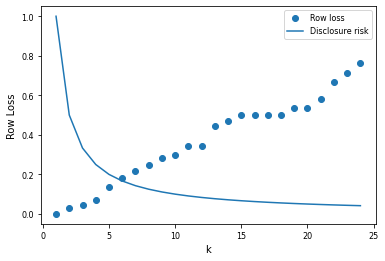

In [8]:
losses = np.array(losses)
plt.scatter(ks, losses/len(generalized), label = "Row loss")
plt.plot(ks, np.ones(len(ks))/ks, label = "Disclosure risk")
plt.xlabel('k')
plt.ylabel('Row Loss')
# plt.title('Row loss as a function of the k parameter')
plt.legend()
plt.show()

In [9]:
# my own sanity check, nevermind this part
unknowns =  k_anonymous.loc[k_anonymous['MARITAL'] ==  'unknown']
singles = k_anonymous.loc[k_anonymous['MARITAL'] ==  'S']
maried = k_anonymous.loc[k_anonymous['MARITAL'] ==  'M']

In [65]:
# Make all datasets anonymous for np.arange(1, 26, 2) and store them in seperate files so 
# recalculation is not needed every time
ks = np.arange(1, 26, 2)

print(ks)
for n in ns:
    print(n)
    patients = execute_local(con, f'select * from patients{n}')
    df = clean_input(patients)
    
    generalized = generalize(df[['AGE']], depths)
    generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")

    
    for k in np.append(ks, [10, 20]):
        filepath = Path(f'Data/Anonymized/kAnonymization/k{k}n{n}.csv') 
        k_anonymous = make_k_anonymous(generalized, k)
        k_anonymous.to_csv(filepath)

[ 1  3  5  7  9 11 13 15 17 19 21 23 25]
100
250
500
1000
1500
2000


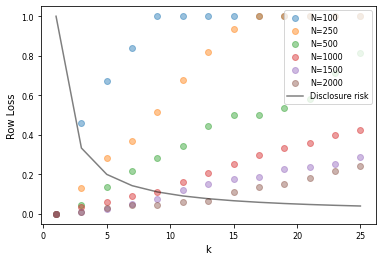

In [66]:
# Row loss plot for different values of k
ks = np.arange(1, 26, 2)
colors = ['red', 'green', 'blue', 'cyan', 'm','black']

for (n, color) in zip(ns, colors):
    patients = execute_local(con, f'select * from patients{n}')
    df = clean_input(patients)
    
    generalized = generalize(df[['AGE']], depths)
    generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
    generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")

    losses = []
    for k in ks:
        anonimized = pd.read_csv(f'Data/Anonymized/kAnonymization/k{k}n{n}.csv')
        losses.append(generalized.shape[0]- anonimized.shape[0])
    losses = np.array(losses)
    plt.scatter(ks, losses/len(generalized), label=f'N={n}', alpha=.45)


plt.plot(ks, np.ones(len(ks))/ks, label = "Disclosure risk", alpha=0.5, color='black')
plt.xlabel('k')
plt.ylabel('Row Loss')
plt.legend(framealpha=0.5)
plt.legend(loc="upper right")

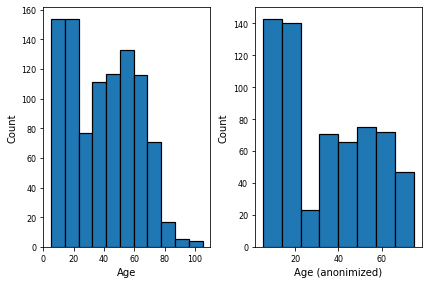

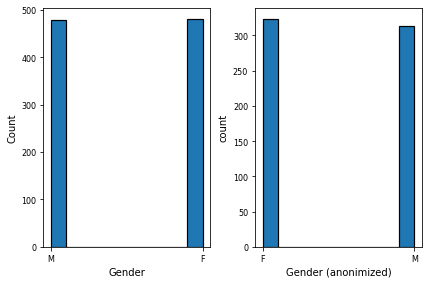

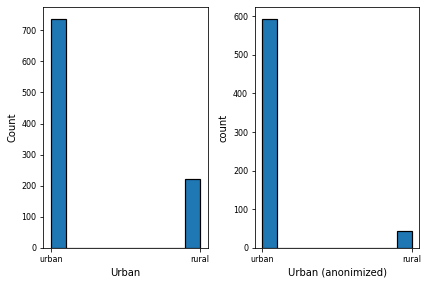

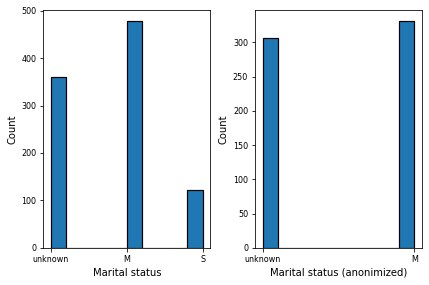

In [67]:
anonimized = pd.read_csv(f'Data/Anonymized/kAnonymization/k{20}n{1000}.csv')

patients = execute_local(con, f'select * from patients{1000}')
df = clean_input(patients)

generalized = generalize(df[['AGE']], depths)
generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")

plt.subplot(1, 2, 2)
plt.hist(anonimized['AGE'], bins=anonimized.AGE.unique().size,
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age (anonimized)')
plt.ylabel('Count')

plt.subplot(1, 2, 1)
plt.hist(generalized['AGE'], generalized.AGE.unique().size, 
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('age dist.png')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(anonimized['GENDER'], edgecolor='black', linewidth=1.2)
plt.xlabel('Gender (anonimized)')
plt.ylabel('count')

plt.subplot(1, 2, 1)
plt.hist(generalized['GENDER'], edgecolor='black', linewidth=1.2)
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('gender dist.png')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(anonimized['URBAN'], edgecolor='black', linewidth=1.2)
plt.xlabel('Urban (anonimized)')
plt.ylabel('count')

plt.subplot(1, 2, 1)
plt.hist(generalized['URBAN'], edgecolor='black', linewidth=1.2)
plt.xlabel('Urban')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('urban dist.png')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(anonimized['MARITAL'], edgecolor='black', linewidth=1.2)
plt.xlabel('Marital status (anonimized)')
plt.ylabel('Count')

plt.subplot(1, 2, 1)
plt.hist(generalized['MARITAL'], edgecolor='black', linewidth=1.2)

plt.xlabel('Marital status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('marital dist.png')
plt.show()

In [70]:
from kmodes.kprototypes import KPrototypes

anonimized = anonimized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]
cat_idx = [1,2,3]


kproto = KPrototypes(n_clusters=8, init='Huang', n_init=5, verbose=0)
kproto.fit(anonimized, categorical=cat_idx)

clusters = kproto.predict(anonimized, categorical=cat_idx)

anonimized['cluster'] = list(clusters)
# print(anonimized)

# anonimized[anonimized['cluster']==6]
print(kproto.cluster_centroids_[kproto.cluster_centroids_[:,0].argsort()])

[['16.411042944785276' 'M' 'urban' 'unknown']
 ['35.0' 'M' 'urban' 'M']
 ['45.0' 'M' 'urban' 'M']
 ['45.0' 'F' 'urban' 'M']
 ['5.0' 'F' 'urban' 'unknown']
 ['55.0' 'M' 'urban' 'M']
 ['65.0' 'F' 'urban' 'M']
 ['75.0' 'M' 'urban' 'M']]


In [69]:
from kmodes.kprototypes import KPrototypes

patients = execute_local(con, f'select * from patients{1000}')
df = clean_input(patients)

generalized = generalize(df[['AGE']], depths)
generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")

generalized = generalized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]
cat_idx = [1,2,3]

kproto = KPrototypes(n_clusters=8, init='Huang', n_init=5, verbose=0)
kproto.fit(generalized, categorical=cat_idx)

clusters = kproto.predict(generalized, categorical=cat_idx)

generalized['cluster'] = list(clusters)

centroids = kproto.cluster_centroids_

centroids[:,[0]] = centroids[:,[0]].astype(float)

print(centroids[centroids[:,0].argsort(kind='mergesort')])

[['15.0' 'M' 'urban' 'unknown']
 ['25.0' 'F' 'urban' 'unknown']
 ['35.0' 'M' 'urban' 'M']
 ['45.0' 'M' 'urban' 'M']
 ['5.0' 'F' 'urban' 'unknown']
 ['55.0' 'M' 'urban' 'M']
 ['65.0' 'F' 'urban' 'M']
 ['79.02061855670104' 'M' 'urban' 'M']]


Can't cluster with 9 clusters


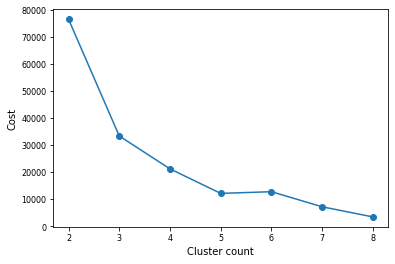

In [91]:
costs = []
n_clusters = []
cat_cols = [1, 2, 3]
for i in range(2, 10):
    try:
        kproto = KPrototypes(n_clusters=i, init='Huang', n_init=3, verbose=0)
        clusters = kproto.fit_predict(anonimized, categorical=cat_cols)
        costs.append(kproto.cost_)
        n_clusters.append(i)
    except:
        print(f"Can't cluster with {i} clusters")
plt.plot(n_clusters, costs)
plt.scatter(n_clusters, costs)
# plt.scatter(4, costs[2], s=80, facecolors='none', edgecolors='r')
plt.xlabel('Cluster count')
plt.ylabel('Cost')
plt.savefig('cluster costs.png')
plt.show()

In [82]:
anonimized = anonimized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]
cat_idx = [1,2,3]
n_clusters = 4

kproto = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
kproto.fit(anonimized, categorical=cat_idx)

clusters = kproto.predict(anonimized, categorical=cat_idx)

anonimized['cluster'] = list(clusters)
# print(anonimized)

# anonimized[anonimized['cluster']==6]
print(kproto.cluster_centroids_[kproto.cluster_centroids_[:,0].argsort()])

patients = execute_local(con, f'select * from patients{1000}')
df = clean_input(patients)
generalized = generalize(df[['AGE']], depths)
generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")
generalized = generalized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]

cat_idx = [1,2,3]

kproto = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
kproto.fit(generalized, categorical=cat_idx)

clusters = kproto.predict(generalized, categorical=cat_idx)

generalized['cluster'] = list(clusters)

centroids = kproto.cluster_centroids_

centroids[:,[0]] = centroids[:,[0]].astype(float)

print(centroids[centroids[:,0].argsort(kind='mergesort')])

[['32.5531914893617' 'F' 'urban' 'M']
 ['50.319148936170215' 'M' 'urban' 'M']
 ['68.94957983193277' 'F' 'urban' 'M']
 ['9.946996466431095' 'M' 'urban' 'unknown']]
[['10.0' 'M' 'urban' 'unknown']
 ['30.904255319148938' 'M' 'urban' 'M']
 ['50.32' 'M' 'urban' 'M']
 ['71.3849765258216' 'F' 'urban' 'M']]


In [117]:
anonimized = anonimized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]
cat_idx = [1,2,3]
n_clusters = 4

kproto_anon = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
kproto_anon.fit(anonimized, categorical=cat_idx)
clusters_anon = kproto_anon.predict(anonimized, categorical=cat_idx)

patients = execute_local(con, f'select * from patients{1000}')
df = clean_input(patients)
generalized = generalize(df[['AGE']], depths)
generalized = pd.concat([generalized, df[['GENDER']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['MARITAL']]], axis=1, join="inner")
generalized = pd.concat([generalized, df[['URBAN']]], axis=1, join="inner")
generalized = generalized[['AGE', 'GENDER', 'URBAN', 'MARITAL']]

kproto_orig = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
kproto_orig.fit(generalized, categorical=cat_idx)
clusters_orig = kproto_orig.predict(generalized, categorical=cat_idx)

In [121]:
from sklearn.metrics import accuracy_score

test_set = generalized[~generalized.apply(tuple,1).isin(anonimized.apply(tuple,1))]

clusters_test_orig = kproto_orig.predict(test_set, categorical=cat_idx)
clusters_test_anon = kproto_anon.predict(test_set, categorical=cat_idx)

print(kproto_orig.cluster_centroids_)
print(kproto_anon.cluster_centroids_)

print(clusters_test_orig)

for i in range(len(clusters_test_orig)):
    if clusters_test_anon[i] == 0:
        clusters_test_anon[i] = 2
    if clusters_test_anon[i] == 2:
        clusters_test_anon[i] = 0

print(accuracy_score(clusters_test_orig, clusters_test_anon))

[['50.32' 'M' 'urban' 'M']
 ['71.3849765258216' 'F' 'urban' 'M']
 ['30.904255319148938' 'M' 'urban' 'M']
 ['10.0' 'M' 'urban' 'unknown']]
[['32.5531914893617' 'F' 'urban' 'M']
 ['68.94957983193277' 'F' 'urban' 'M']
 ['50.319148936170215' 'M' 'urban' 'M']
 ['9.946996466431095' 'M' 'urban' 'unknown']]
[2 0 0 1 0 3 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 2 0 2 0 0 1 0 2 3 1 1 2 0 2 2 2
 1 2 0 1 3 3 2 2 2 1 0 0 0 2 2 1 0 0 2 2 2 2 3 2 1 1 1 0 2 0 0 1 3 3 0 3 2
 3 0 2 1 1 1 1 2 2 0 1 3 0 2 0 1 0 1 1 0 0 1 2 0 3 1 1 2 1 1 0 2 1 1 0 0 0
 1 0 0 0 1 1 2 1 0 0 0 3 1 1 2 2 0 3 1 1 2 1 2 1 1 2 0 1 0 2 1 0 0 1 0 1 3
 0 0 1 1 2 2 2 1 1 1 2 3 3 0 1 2 0 1 2 0 0 0 2 3 1 0 1 0 0 2 2 1 2 2 1 2 0
 2 1 0 2 2 0 3 0 0 1 2 2 2 0 1 0 3 0 2 1 0 1 0 0 1 0 2 0 0 0 0 2 2 1 2 2 2
 2 1 2 2 0 2 1 1 0 0 0 2 2 3 1 2 2 2 3 3 2 0 0 1 2 2 1 2 2 1 2 1 0 1 0 2 0
 0 0 0 0 1 1 1 2 0 0 2 1 0 2 0 0 1 2 2 0 2 1 2 1 1 1 3 1 0 3 1 0 3 2 1 1 2
 0 0 0 1 2 0 0 0 2 1 0 0 2 1 2 2 2 2 0 0 1 1 1 2 0 1]
0.7080745341614907
